# Spatial Alignment with scGALA-enhanced STAligner

This tutorial demonstrates how to align spatial transcriptomics datasets using scGALA with STAligner. The scGALA framework enhances existing integration methods like STAligner by replacing their core cell alignment modules while preserving their established workflows.

## Overview

The scGALA enhancement strategy for spatial alignment:
1. Capitalizes on robust graph-based alignments generated through the GAT architecture
2. Utilizes score-based optimization to improve spatial spot matching
3. Seamlessly integrates these improved alignments into the STAligner pipeline
4. Maintains the fundamental structure of the spatial alignment method while upgrading alignment capabilities

In this tutorial, we'll align spatial transcriptomics slices from mouse brain samples using the scGALA-enhanced STAligner workflow.

## Preparation

First, let's set up our environment and suppress warnings to keep our output clean.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## scGALA Enhancement Implementation

In this tutorial, we'll use the scGALA-enhanced STAligner alignment algorithm. The core enhancement is in the `train_STAligner_subgraph_mod` function, which replaces the standard STAligner alignment approach with scGALA's graph-based alignment method. The modified code can be accessed in the [scripts folder](https://github.com/mcgilldinglab/scGALA/tree/main/docs/tutorials/scripts).

Let's load the necessary libraries and the enhanced STAligner implementation.

In [ ]:
from STAligner import STAligner
from scSLAT.model import spatial_match
from scSLAT.metrics import global_score, euclidean_dis, rotation_angle
from scSLAT.viz import match_3D_multi, matching_2d
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import yaml


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data Loading

We'll use two consecutive spatial transcriptomics slices from a mouse brain sample. The data includes gene expression measurements and spatial coordinates for each spot. The goal is to align these slices in a biologically meaningful way.

The enhanced STAligner method will use both the gene expression patterns and the spatial information to find optimal alignments between the slices.

### Data availability

The example data represents adjacent sections from mouse brain spatial transcriptomics experiment. Each section contains spots with gene expression data and spatial coordinates. The data also includes cell type and layer annotations for evaluation purposes.

The data is available for download from [Figshare](https://figshare.com/articles/dataset/Label_Transfer_Example_Data/28728617).

In [ ]:
Batch_list = []
adj_list = []
section_ids = ['adata1','adata2']
sample = '/'
print(section_ids)

for section_id in section_ids:
    print(section_id)
    # Load spatial transcriptomics data (h5ad format)
    adata = sc.read_h5ad("Data/"+sample+section_id+".h5ad")
    adata.X = csr_matrix(adata.X)
    adata.var_names_make_unique(join="++")

    # Make spot names unique by adding section ID
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]    
    
    # Construct spatial neighborhood network based on physical distances
    # This step is important for capturing spatial relationships between spots
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=50) # the spatial network are saved in adata.uns['adj']
    # ST_utils.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
       
    # Normalize gene expression data
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=8000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Filter to only keep highly variable genes
    adata = adata[:, adata.var['highly_variable']]
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['adata1', 'adata2']
adata1
------Calculating spatial graph...
The graph contains 181750 edges, 3635 cells.
50.0000 neighbors per cell on average.
adata2
------Calculating spatial graph...
The graph contains 171550 edges, 3431 cells.
50.0000 neighbors per cell on average.


## Creating a Combined AnnData Object

Next, we'll concatenate the individual AnnData objects for the different slices into a single object. This combined object will track which slice each spot originates from, facilitating the subsequent alignment and integration steps.

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (7066, 5711)


In [5]:
adata_concat

AnnData object with n_obs × n_vars = 7066 × 5711
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'cell_type', 'slice_name', 'batch_name'
    obsm: 'X_harmony', 'X_pca', 'spatial'
    layers: 'counts'

In [6]:
adata_concat.obs

,in_tissue,array_row,array_col,imagerow,imagecol,sum_umi,sum_gene,subject,position,replicate,...,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts,cell_type,slice_name,batch_name
AAACAAGTATCTCCCA-1.9_adata1,1,50,102,384.023416,438.028818,10368,3875,Br8100,0,2,...,10368.0,9.246576,28.173225,33.603395,41.049383,54.591049,10269.0,1,adata1,adata1
AAACAATCTACTAGCA-1.4_adata1,1,3,43,129.297934,257.110720,3999,2225,Br8100,0,2,...,3999.0,8.294049,21.430358,27.631908,36.409102,53.588397,3941.0,0,adata1,adata1
AAACACCAATAACTGC-1.9_adata1,1,59,19,430.648080,180.513058,4800,2408,Br8100,0,2,...,4800.0,8.476580,25.437500,32.354167,41.520833,56.395833,4741.0,2,adata1,adata1
AAACAGAGCGACTCCT-1.8_adata1,1,14,94,189.783985,414.671481,7974,3326,Br8100,0,2,...,7974.0,8.984067,28.806120,34.499624,41.973915,55.505393,7892.0,1,adata1,adata1
AAACAGCTTTCAGAAG-1.8_adata1,1,43,9,344.149427,150.180023,4086,2110,Br8100,0,2,...,4086.0,8.315566,27.239354,33.798336,42.535487,58.467939,4041.0,3,adata1,adata1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1.11_adata2,1,31,77,287.038714,357.605773,2880,1638,Br8100,300,2,...,2880.0,7.965893,25.798611,32.222222,42.187500,60.486111,2835.0,0,adata2,adata2
TTGTTTCACATCCAGG-1.11_adata2,1,58,42,431.773192,248.064815,2640,1526,Br8100,300,2,...,2640.0,7.878913,26.818182,33.522727,43.219697,61.136364,2583.0,2,adata2,adata2
TTGTTTCATTAGTCTA-1.11_adata2,1,60,30,442.259241,210.801087,2063,1279,Br8100,300,2,...,2063.0,7.632401,27.532719,35.046049,44.789142,62.239457,2013.0,2,adata2,adata2
TTGTTTCCATACAACT-1.11_adata2,1,45,27,361.341147,202.115218,1031,748,Br8100,300,2,...,1031.0,6.939254,27.546072,37.148400,46.847721,75.945684,1007.0,4,adata2,adata2


## Running scGALA-enhanced STAligner

Now we'll run the enhanced STAligner algorithm, which incorporates scGALA's graph-based alignment approach. This is the core of the enhancement, where we replace the standard triplet-based alignment method with scGALA's Graph Attention Network (GAT) architecture.

The enhanced approach:
1. Uses graph attention to better capture the spatial context of each spot
2. Applies more robust matching between spots across slices
3. Preserves spatial relationships during alignment
4. Handles technical variations more effectively

The `train_STAligner_subgraph_mod` function has been modified to incorporate these enhancements while maintaining the overall workflow of STAligner.

In [ ]:
%%time
# iter_comb is used to specify the order of integration. For example, (0, 1) means slice 0 will be algined with slice 1 as reference.
iter_comb = [(0, 1)] #, (2, 3), (3, 4), (4, 5), (5, 6)

# Here we use the scGALA-enhanced STAligner function (subgraph_mod) instead of the standard one
# This is where scGALA's graph-based alignment replaces STAligner's traditional alignment approach
adata_concat = STAligner.train_STAligner_subgraph_mod(adata_concat, verbose=True, knn_neigh = 20, n_epochs = 600, iter_comb = iter_comb, 
                                                        Batch_list=Batch_list, device=used_device,spatial=True)

STAligner(
  (conv1): GATConv(5711, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 5711, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:34<00:00, 14.38it/s]


Train with STAligner...


  0%|          | 0/100 [00:00<?, ?it/s]

Update spot triplets at epoch 500
normalizing


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


start to train


2024-05-17 09:43:46.921650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 09:43:47.533391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | MSVGAE            | 73.4 K
1 | criterion | TripletMarginLoss | 0     
------------------------------------------------
73.4 K    Trainable params
0         Non-trainable params
73.4 K    Total params
0.293     Total estimated model params size (MB)


Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s, v_num=19, total_loss=1.030, vae_loss=0.886, spatial_triplet_loss=0.130, auc=0.980, ap=0.970, ave_align=235.0]         

Trainer was signaled to stop but the required `min_epochs=10` or `min_steps=None` has not been met. Training will continue...


Epoch 9: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s, v_num=19, total_loss=1.010, vae_loss=0.875, spatial_triplet_loss=0.119, auc=0.984, ap=0.977, ave_align=223.0] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



Model Training Time: 62.43777346611023 Seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.29it/s]
0.95 0.3


 99%|█████████▉| 98.83707774851592/100 [01:15<00:00,  1.31it/s, epoch=69, marriage_sum=5.8e+3, max_aligned_R=3, aligned_R=2937, mean_aligned_R=2.03, max_aligned_D=3, aligned_D=3110, mean_aligned_D=1.91] 


R:3431 D:3635


100%|██████████| 100/100 [03:04<00:00,  1.85s/it] 


CPU times: user 23min 54s, sys: 34min 23s, total: 58min 17s
Wall time: 3min 41s


## Clustering the Aligned Data

After alignment, we can perform clustering on the integrated dataset. This clustering should be more coherent across slices because the alignment has brought corresponding regions into the same latent space. We'll use the Louvain algorithm, which is commonly used for community detection in single-cell data analysis.

In [ ]:
# Build a k-nearest neighbor graph using the STAligner latent representation
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
# Apply Louvain clustering with appropriate resolution
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=0.2)

## Visualization of Integration Results

Let's visualize the results of our integration. We'll first look at a UMAP projection of the combined dataset, which should show good mixing of spots from different slices if the alignment was successful. Then, we'll visualize the spatial locations and clustering results.

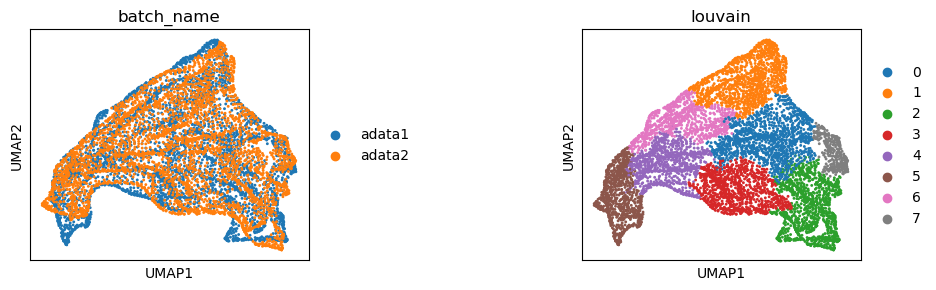

In [10]:
sc.tl.umap(adata_concat, random_state=666)

import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 10

sc.pl.umap(adata_concat, color=['batch_name', 'louvain'], ncols=2, wspace=0.8, show=True)

### Visualizing Cluster Assignments in Spatial Context

Now let's examine how the clusters are distributed spatially across the slices. This will help us assess whether the alignment has preserved the spatial structure of the tissue while matching similar regions across slices.

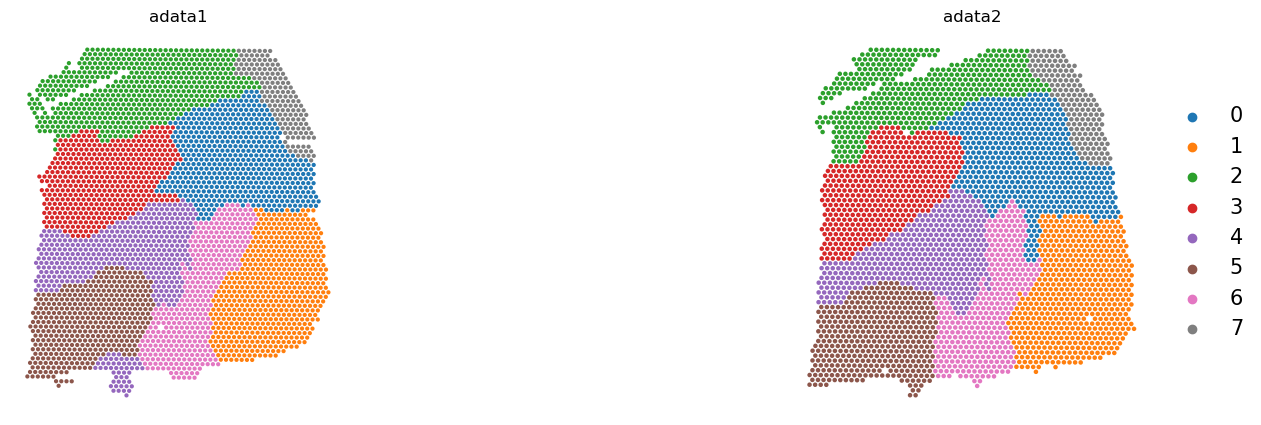

In [ ]:
# Transfer clustering results back to the original AnnData objects
for it in range(len(section_ids)):
    Batch_list[it].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[it]].obs['louvain'].values

# Plotting parameters
spot_size = 5
title_size = 15
fig, ax = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for it in range(len(section_ids)):
    if it == 1:
        _sc_0= sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_fontsize=15, show=False, ax=ax[it], frameon=False, spot_size=spot_size)        
    else:
        _sc_0 = sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_loc=None, show=False, ax=ax[it], frameon=False, spot_size=spot_size)

plt.show()

### Identifying a Landmark Domain for Alignment

For more precise spatial alignment, we'll identify a landmark domain (a distinct anatomical region) that can guide the alignment process. This domain should be clearly identifiable in both slices.

In [ ]:
# Select a specific cluster as our landmark domain
landmark_domain = '1'

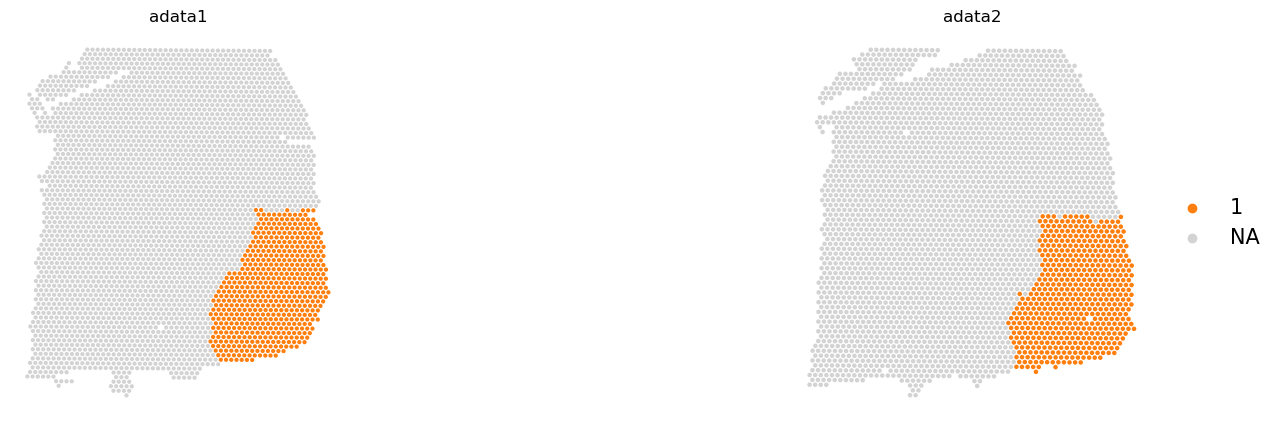

In [ ]:
# Visualize only the landmark domain across slices to verify its consistency
# This domain will guide the physical alignment of the slices
fig, ax = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for it in range(len(section_ids)):
    if it == 1:
        _sc_0= sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_fontsize=15, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])        
    else:
        _sc_0 = sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_loc=None, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])

plt.show()

In [14]:
for it in range(len(section_ids)):
    Batch_list[it].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[it]].obs['louvain'].values

## Spatial Domain-Guided 3D Slice Alignment

After identifying corresponding regions (landmark domain) across slices using the scGALA-enhanced alignment, we can now apply physical alignment using the Iterative Closest Point (ICP) algorithm. This step transforms the spatial coordinates of one slice to align with another, enabling 3D reconstruction of the tissue.

The key innovation here is that we use the robust scGALA-identified mutual nearest neighbors within the landmark domain to guide the ICP algorithm, resulting in more accurate physical alignment.

In [15]:
iter_comb = [(0,1)]
for comb in iter_comb:
    print(comb)
    i, j = comb[0], comb[1]
    adata_target = Batch_list[i]
    adata_ref = Batch_list[j]
    slice_target = section_ids[i]
    slice_ref = section_ids[j]
    
    aligned_coor = STAligner.ICP_align(adata_concat, adata_target, adata_ref, slice_target, slice_ref, [landmark_domain])
    adata_target.obsm["spatial"] = aligned_coor

(0, 1)


## Visualizing Results After Coordinates Alignment

Let's look at the alignment results after the physical transformation. If the alignment is successful, the landmark domain should have similar spatial distributions in both slices.

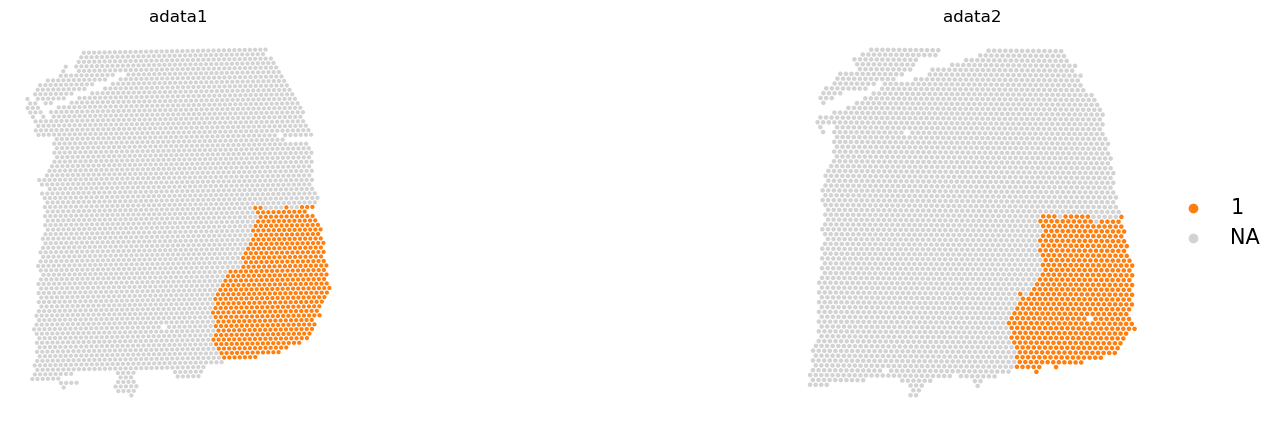

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for it in range(len(section_ids)):
    if it == 1:
        _sc_0= sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_fontsize=15, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])        
    else:
        _sc_0 = sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_loc=None, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])

plt.show()

### Preparing for 3D Visualization

Now that we have aligned the slices in 2D, we can add a Z-coordinate to create a 3D visualization of the stacked slices. This helps us see how the tissue structure continues across consecutive sections.

In [17]:
adata_concat.obs['X'] = adata_concat.obsm['spatial'][:, 0]
adata_concat.obs['Y'] = adata_concat.obsm['spatial'][:, 1]

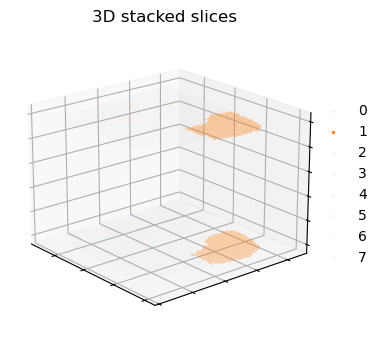

In [ ]:
adata_concat.obs['Z'] = list(Batch_list[0].shape[0] * [0]) + list(Batch_list[1].shape[0] * [10])

All_coor = adata_concat.obs[['X', 'Y', 'Z']].copy()
All_coor.iloc[adata_concat.obs['batch_name'] == section_ids[0], :2] = Batch_list[0].obsm["spatial"]
All_coor.iloc[adata_concat.obs['batch_name'] == section_ids[1], :2] = Batch_list[1].obsm["spatial"]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 4))
ax1 = plt.axes(projection='3d')

for it, label in enumerate(np.unique(adata_concat.obs['louvain'])):
    temp_Coor = All_coor.loc[adata_concat.obs['louvain'] == label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    if label == landmark_domain:
        ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata_concat.uns['louvain_colors'][it],
                      s=0.02, marker="o", label=label, alpha=1)
    else:
        ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata_concat.uns['louvain_colors'][it],
                      s=0.02, marker="o", label=label, alpha=0.05)        
    
plt.legend(bbox_to_anchor=(1.2, 0.8), markerscale=10, frameon=False)
plt.title('3D stacked slices')
ax1.elev = 20
ax1.azim = -40

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])   

plt.show()

## Benchmark and Evaluation

To quantitatively assess the performance of our scGALA-enhanced STAligner, we'll evaluate the alignment using several metrics. First, we need to identify the matching spots between slices based on the STAligner embeddings.

In [ ]:
# Extract embddings for each slice
adata1 = adata_concat[adata_concat.obs['slice_name']=='adata1']
adata2 = adata_concat[adata_concat.obs['slice_name']=='adata2']
embd0 = adata1.obsm['STAligner']
embd1 = adata2.obsm['STAligner']
# Find the best matching spots between slices based on embeddings
best, index, distance = spatial_match([embd0, embd1],reorder=False)
matching = np.array([range(index.shape[0]), best])

In [20]:
matching

array([[   0,    1,    2, ..., 3428, 3429, 3430],
       [ 241,    1, 2899, ...,  922, 1184, 2364]])

### Setting Up Evaluation Parameters

We'll define the parameters for evaluating the alignment quality. This includes the biological and topological metadata to compare, and output directories for saving results.

In [21]:
ground_truth = 60
biology_meta = 'cell_type'
topology_meta = 'layer_guess'
out_dir = Path('/mnt/md0/guo/Projects/Multiomics/modualize/Spatial/Result/STAligner/triplet_mod')
sc.settings.figdir = out_dir
metric_file='/mnt/md0/guo/Projects/Multiomics/modualize/Spatial/Result/STAligner/triplet_mod/metric.txt'
matching_file = '/mnt/md0/guo/Projects/Multiomics/modualize/Spatial/Result/STAligner/triplet_mod/matching.txt'

### Global Alignment Score

We'll compute global alignment scores that consider both biological (cell type) and topological (layer) information. These scores measure how well the alignment preserves biological and spatial structures.

In [23]:
overall_score = global_score([adata1,adata2], matching.T, biology_meta, topology_meta)
celltype_score = global_score([adata1,adata2], matching.T, biology_meta=biology_meta)
region_score = global_score([adata1,adata2], matching.T, topology_meta=topology_meta)
print('Overall score: ', overall_score, 'Celltype score: ', celltype_score, 'Region score: ', region_score)

Warning! column  not in adata.obs 
Warning! column  not in adata.obs 
Overall score:  0.5470708248324104 Celltype score:  0.6420868551442728 Region score:  0.8394054211600117


### Euclidean Distance Evaluation

We'll also calculate the average Euclidean distance between matched spots after alignment, which measures the physical accuracy of the alignment.

In [24]:
eud = euclidean_dis(adata1, adata2, matching)

## F1 Score Evaluation

F1 scores provide a balanced measure of precision and recall for the alignment. We'll compute F1 scores for cell type matching, layer matching, and the combined cell type-layer matching.

In [ ]:
# Prepare for F1 score calculation by transferring labels based on the matching
# if 'visium' and 'DLPFC' in adata1_file:
#     adata2.obs[biology_meta] = 'celltype_' + adata2.obs[biology_meta].astype('str')
#     adata1.obs[biology_meta] = 'celltype_' + adata1.obs[biology_meta].astype('str')

# Transfer cell type and region labels from matched spots in slice 1 to slice 2
adata2.obs['target_celltype'] = adata1.obs.iloc[matching[1,:],:][biology_meta].to_list()
adata2.obs['target_region'] = adata1.obs.iloc[matching[1,:],:][topology_meta].to_list()
adata2.obs['target_celltype_region'] = adata2.obs['target_celltype'].astype('str') + '_' + adata2.obs['target_region'].astype('str')
adata2.obs['celltype_region'] = adata2.obs[biology_meta].astype('str') + adata2.obs[topology_meta].astype('str')

In [ ]:
# Calculate F1 scores for different aspects of the alignment
# Cell type F1 scores (how well cell types match between aligned spots)
celltype_macro_f1 = f1_score(adata2.obs[biology_meta], adata2.obs['target_celltype'], average='macro')
celltype_micro_f1 = f1_score(adata2.obs[biology_meta], adata2.obs['target_celltype'], average='micro')

# Region/layer F1 scores (how well anatomical regions match)
region_macro_f1 = f1_score(adata2.obs[topology_meta], adata2.obs['target_region'], average='macro')
region_micro_f1 = f1_score(adata2.obs[topology_meta], adata2.obs['target_region'], average='micro')

# Combined cell type and region F1 scores
total_macro_f1 = f1_score(adata2.obs['celltype_region'], adata2.obs['target_celltype_region'], average='macro')
total_micro_f1 = f1_score(adata2.obs['celltype_region'], adata2.obs['target_celltype_region'], average='micro')

## Confusion Matrix Visualization

Confusion matrices provide a detailed view of which cell types or regions are being matched correctly or confused with each other. This helps us identify specific strengths or weaknesses in the alignment.

In [27]:
celltype_label = adata2.obs[biology_meta].unique().tolist()
region_label = adata2.obs[topology_meta].unique().tolist()
celltype_region_label = adata2.obs['celltype_region'].unique().tolist()

### Cell Type Confusion Matrix

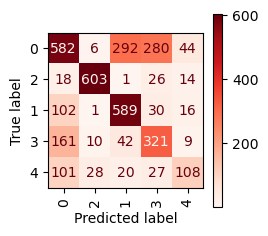

In [29]:
plt.figure(figsize=(len(celltype_label) / 2, len(celltype_label) /2))
cm = confusion_matrix(adata2.obs[biology_meta], adata2.obs['target_celltype'], labels=celltype_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=celltype_label)
disp.plot(cmap='Reds', xticks_rotation='vertical', ax=plt.gca())
plt.savefig(out_dir / 'celltype_confusing_matrix.png', dpi=300, bbox_inches='tight')

### Region/Layer Confusion Matrix

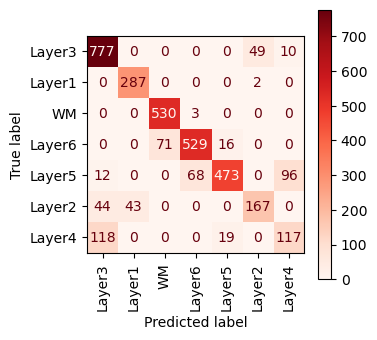

In [30]:
plt.figure(figsize=(len(region_label) / 2, len(region_label) /2))
cm = confusion_matrix(adata2.obs[topology_meta], adata2.obs['target_region'], labels=region_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=region_label)
disp.plot(cmap='Reds', xticks_rotation='vertical', ax=plt.gca())
# plt.savefig(out_dir / 'region_confusing_matrix.png', dpi=300, bbox_inches='tight')

## Saving Evaluation Results

Let's save all the evaluation metrics we've calculated to a file for future reference and comparison with other methods.

In [31]:
metric_dic = {}
metric_dic['global_score'] = overall_score
metric_dic['celltype_score'] = celltype_score
metric_dic['region_score'] = region_score
metric_dic['euclidean_dis'] = eud
metric_dic['angle_delta'] = float(angle)
# metric_dic['run_time'] = run_time

metric_dic['celltype_macro_f1'] = float(celltype_macro_f1)
metric_dic['celltype_micro_f1'] = float(celltype_micro_f1)
metric_dic['region_macro_f1'] = float(region_macro_f1)
metric_dic['region_micro_f1'] = float(region_micro_f1)
metric_dic['total_macro_f1'] = float(total_macro_f1)
metric_dic['total_micro_f1'] = float(total_micro_f1)

# metric_dic['match_ratio'] = float(match_ratio)

with open(metric_file, "w") as f:
    yaml.dump(metric_dic, f)

if 'paste' not in metric_file.lower():
    np.savetxt(matching_file, matching, fmt='%i')

## Advanced Visualization of Alignment Results

Now we'll create more detailed visualizations of the alignment results. These visualizations help us understand the quality of the alignment and can be useful for presentations and publications.

### Preparing Data for Visualization

In [32]:
adata1_df = pd.DataFrame({'index':range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs[biology_meta],
                          'region':adata1.obs[topology_meta]})
adata2_df = pd.DataFrame({'index':range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs[biology_meta],
                          'region':adata2.obs[topology_meta]})

### 3D Matching Visualization by Cell Type

dataset1: 5 cell types; dataset2: 5 cell types; 
                    Total :5 celltypes; Overlap: 5 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 3431


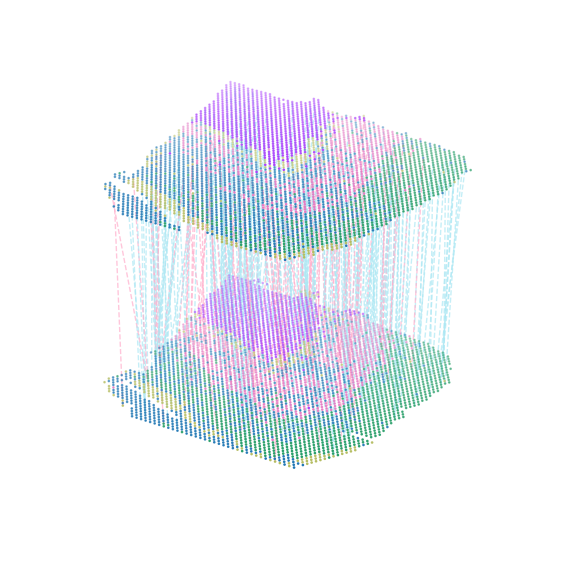

In [33]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[0.8,0.8], 
                    hide_axis=True, show_error=True, save=out_dir / 'match_by_celltype.pdf')

### 3D Matching Visualization by Region/Layer

dataset1: 7 cell types; dataset2: 7 cell types; 
                    Total :7 celltypes; Overlap: 7 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 3431


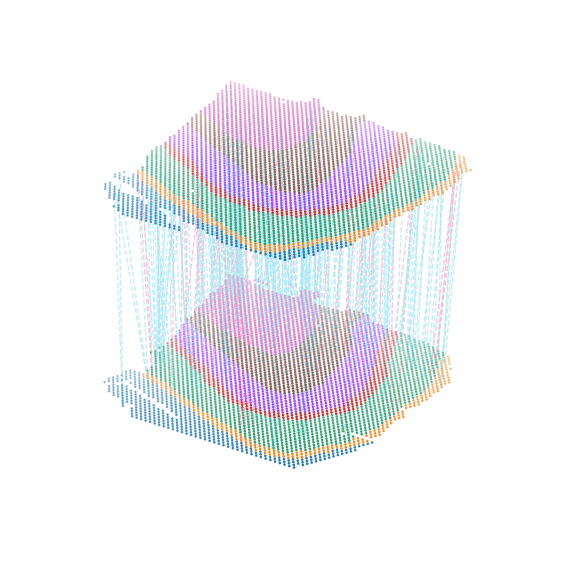

In [34]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='region',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[0.8,0.8], 
                    hide_axis=True, show_error=True, save=out_dir / 'match_by_region.pdf')

### 2D Matching Visualization

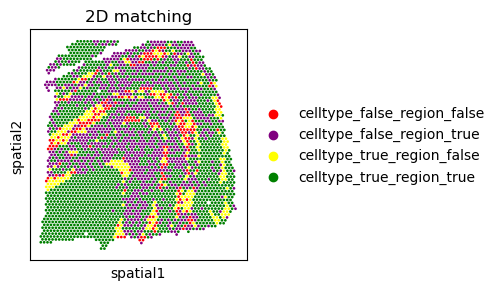

In [35]:
# 2D matching plot
matching_2d(matching, adata1, adata2, biology_meta, topology_meta, spot_size, save='matching_2d.pdf')

## Reverse Matching Analysis

To ensure robustness of the alignment, we can also perform reverse matching (from slice 2 to slice 1) and compare the results with the forward matching (from slice 1 to slice 2).

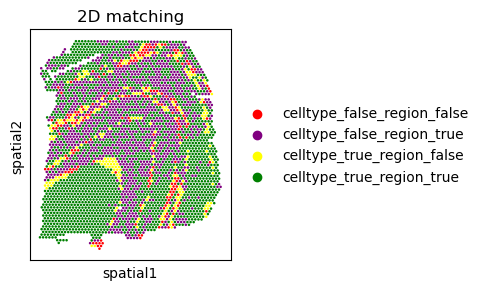

In [37]:
if 'paste' in metric_file.lower():
    matching_2d(matching, adata1, adata2, biology_meta, topology_meta, spot_size, save='matching_rev_2d.pdf')
else:
    best_rev, index_rev, _ = spatial_match([embd1, embd0], adatas=[adata2, adata1], reorder=False)
    matching_rev = np.array([range(index_rev.shape[0]), best_rev])
    matching_2d(matching_rev, adata2, adata1, biology_meta, topology_meta, spot_size, save='matching_rev_2d.pdf')

## Integration Quality Assessment with scIB

Finally, we'll use the single-cell integration benchmarking (scIB) package to evaluate the quality of our integration more comprehensively. This provides standardized metrics that can be compared with other integration methods.

In [38]:
import scib
adata_concat.write_h5ad('./adata_spatial.h5ad')

In [39]:
adata_concat.obs.head()

,in_tissue,array_row,array_col,imagerow,imagecol,sum_umi,sum_gene,subject,position,replicate,...,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts,cell_type,slice_name,batch_name,louvain,X,Y,Z
AAACAAGTATCTCCCA-1.9_adata1,1,50,102,384.023416,438.028818,10368,3875,Br8100,0,2,...,41.049383,54.591049,10269.0,1,adata1,adata1,1,438.028818,384.023416,0
AAACAATCTACTAGCA-1.4_adata1,1,3,43,129.297934,257.110720,3999,2225,Br8100,0,2,...,36.409102,53.588397,3941.0,0,adata1,adata1,2,257.110720,129.297934,0
AAACACCAATAACTGC-1.9_adata1,1,59,19,430.648080,180.513058,4800,2408,Br8100,0,2,...,41.520833,56.395833,4741.0,2,adata1,adata1,5,180.513058,430.648080,0
AAACAGAGCGACTCCT-1.8_adata1,1,14,94,189.783985,414.671481,7974,3326,Br8100,0,2,...,41.973915,55.505393,7892.0,1,adata1,adata1,0,414.671481,189.783985,0
AAACAGCTTTCAGAAG-1.8_adata1,1,43,9,344.149427,150.180023,4086,2110,Br8100,0,2,...,42.535487,58.467939,4041.0,3,adata1,adata1,4,150.180023,344.149427,0


### Optimal Clustering for Evaluation

In [40]:
sc.pp.neighbors(adata_concat, use_rep="STAligner")
scib.me.cluster_optimal_resolution(adata_concat, cluster_key="cluster", label_key="cell_type")

resolution: 0.1, nmi: 0.40532107812341467
resolution: 0.2, nmi: 0.3737920456890244
resolution: 0.3, nmi: 0.3522314892394253
resolution: 0.4, nmi: 0.35254861528328846
resolution: 0.5, nmi: 0.34814467658593656
resolution: 0.6, nmi: 0.33480436103972094
resolution: 0.7, nmi: 0.3455285706251356
resolution: 0.8, nmi: 0.33049551173123426
resolution: 0.9, nmi: 0.33323899760391773
resolution: 1.0, nmi: 0.3312815248760219
resolution: 1.1, nmi: 0.3286496324773276
resolution: 1.2, nmi: 0.3255517923938525
resolution: 1.3, nmi: 0.3288828798147773
resolution: 1.4, nmi: 0.32429643755732784
resolution: 1.5, nmi: 0.32042606771293236
resolution: 1.6, nmi: 0.3189019680392081
resolution: 1.7, nmi: 0.3185929171268004
resolution: 1.8, nmi: 0.3190704752884397
resolution: 1.9, nmi: 0.3136169164643211
resolution: 2.0, nmi: 0.3125201713754562
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.40532107812341467


### Computing Integration Metrics

We'll calculate a comprehensive set of integration metrics, including silhouette scores, graph connectivity, normalized mutual information (NMI), adjusted Rand index (ARI), and others.

In [41]:
metrics = scib.metrics.metrics(adata=adata_concat,
                     adata_int=adata_concat,
                     embed='STAligner',
                     batch_key='slice_name',
                     label_key='cell_type',
        isolated_labels_asw_=True,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=False,
        isolated_labels_f1_=True,
        trajectory_=False,
        nmi_=True,
        ari_=True,
        cell_cycle_=False,
        kBET_=False,
        ilisi_=True,
        clisi_=True,
)
metrics.to_csv('/mnt/md0/guo/Projects/Multiomics/modualize/Spatial/Result/STAligner/triplet_mod/'+'integration_metrics.csv')
metrics

/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning:

Call to deprecated function (or staticmethod) opt_louvain.



NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep STAligner


/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Compute neighbors on rep STAligner
Compute neighbors on rep STAligner
Compute neighbors on rep STAligner
Compute neighbors on rep STAligner
Isolated labels ASW...


/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Graph connectivity...
cLISI score...


/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/mnt/md0/guo/miniforge3/envs/ggmnn_tnn_pot/lib/python3.9/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

/mnt/md0/guo/minifor

iLISI score...


,0
NMI_cluster/label,0.356695
ARI_cluster/label,0.199399
ASW_label,0.556280
ASW_label/batch,0.957177
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,0.569654
isolated_label_silhouette,0.577314
graph_conn,0.873074
kBET,NaN


## Conclusion
In this tutorial, we've demonstrated how scGALA enhances the STAligner spatial alignment workflow. By replacing the standard alignment approach with scGALA's graph-based method, we achieve more accurate alignment of spatial transcriptomics slices while preserving the established STAligner pipeline.

This approach can be applied to other spatial transcriptomics integration methods as well, offering a flexible framework to enhance existing computational tools with more robust alignment capabilities.